In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import sys
import copy
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster, datasets, mixture
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import seaborn as sns
from ExKMC.Tree import Tree as ExTree
from intercluster.rules import *
from intercluster.pruning import *
from intercluster.experiments import *
from intercluster import *

%load_ext autoreload
%autoreload 2

In [2]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 170
np.random.seed(seed)

In [3]:
colorblind_palette = sns.color_palette("colorblind", as_cmap=False)
cmap = ListedColormap(colorblind_palette)
subset_colors = [cmap(0), cmap(4), cmap(9)]
cmap_subset = ListedColormap(subset_colors)
tab20 = plt.get_cmap('tab20')

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 20
})

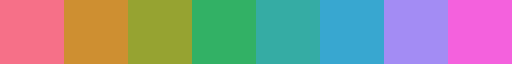

In [4]:
cmap

## Simple Dataset

In [18]:
n = 2000
m = 2
k = 3

random_state = 170
data, labels = datasets.make_blobs(
    n_samples=[1000,700,300], cluster_std=[1.0, 2.5, 0.5], random_state=seed
)
data = preprocessing.MinMaxScaler().fit_transform(data)

In [19]:
np.sum(labels == 0)

1000

In [6]:
'''
n = 2000
m = 2
k = 5

random_state = 1711
data, labels = datasets.make_blobs(
    n_samples=n, centers = k, cluster_std=[1.0, 0.8, 1, 2, 1.2], random_state=random_state
)
data = preprocessing.MinMaxScaler().fit_transform(data)
'''

'\nn = 2000\nm = 2\nk = 5\n\nrandom_state = 1711\ndata, labels = datasets.make_blobs(\n    n_samples=n, centers = k, cluster_std=[1.0, 0.8, 1, 2, 1.2], random_state=random_state\n)\ndata = preprocessing.MinMaxScaler().fit_transform(data)\n'

Text(0, 0.5, 'y')

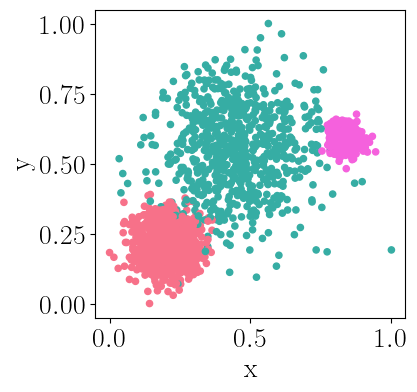

In [20]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
ax.scatter(data[:,0], data[:,1], c = labels, cmap = cmap, alpha = 1, s = 20)
ax.set_xlabel('x')
ax.set_ylabel('y')
#plt.savefig('figures/example_ground_truth.jpg', bbox_inches = 'tight', dpi = 300)

### Kmeans baseline

In [21]:
kmeans = KMeans(n_clusters=k, random_state=seed).fit(data)
kmeans_assignment = labels_to_assignment(kmeans.labels_, n_labels = k)
cost = kmeans_cost(data, kmeans_assignment, kmeans.cluster_centers_)

Text(0, 0.5, 'y')

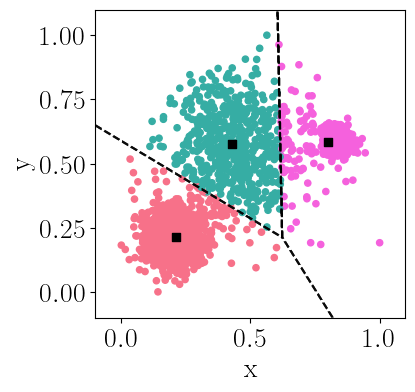

In [22]:
colorswitch = {0:2, 1:0, 2:1}
kmeans_labels_ = np.array([colorswitch[i] for i in kmeans.labels_])
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = kmeans_labels_, cmap = cmap, s = 20)
plot_decision_boundaries(kmeans, data, ax = ax, resolution = 1000)

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'k', s = 30, marker = 's')

#unique_labels = np.unique(kmeans.labels_)
#handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=f'Cluster {label}') for label in unique_labels]

ax.set_xlabel('x')
ax.set_ylabel('y')
#plt.legend(handles=handles, loc = 'upper left')
#plt.savefig('figures/example_kmeans.jpg', bbox_inches = 'tight', dpi = 300)

# Generating Rules

### IMM / ExKMC

In [75]:
# As long as imm = True, ExkmcTree will produce an IMM tree if 
# given max_leaf_nodes = n_clusters.
exkmc_tree = ExkmcTree(
    k = k,
    kmeans = kmeans,
    max_leaf_nodes = 6,
    imm = True
)
exkmc_tree.fit(data)
exkmc_labels = exkmc_tree.predict(data, leaf_labels = False)

Text(0, 0.5, 'y')

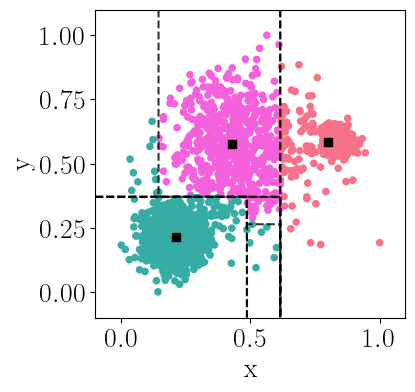

In [76]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
ax.scatter(data[:,0], data[:,1], c = exkmc_labels, cmap = cmap, s = 20)
plot_decision_boundaries(exkmc_tree, data, ax = ax, resolution = 1000)

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'k', s = 30, marker = 's')

ax.set_xlabel('x')
ax.set_ylabel('y')
#plt.savefig('figures/example_imm.jpg', bbox_inches = 'tight', dpi = 300)

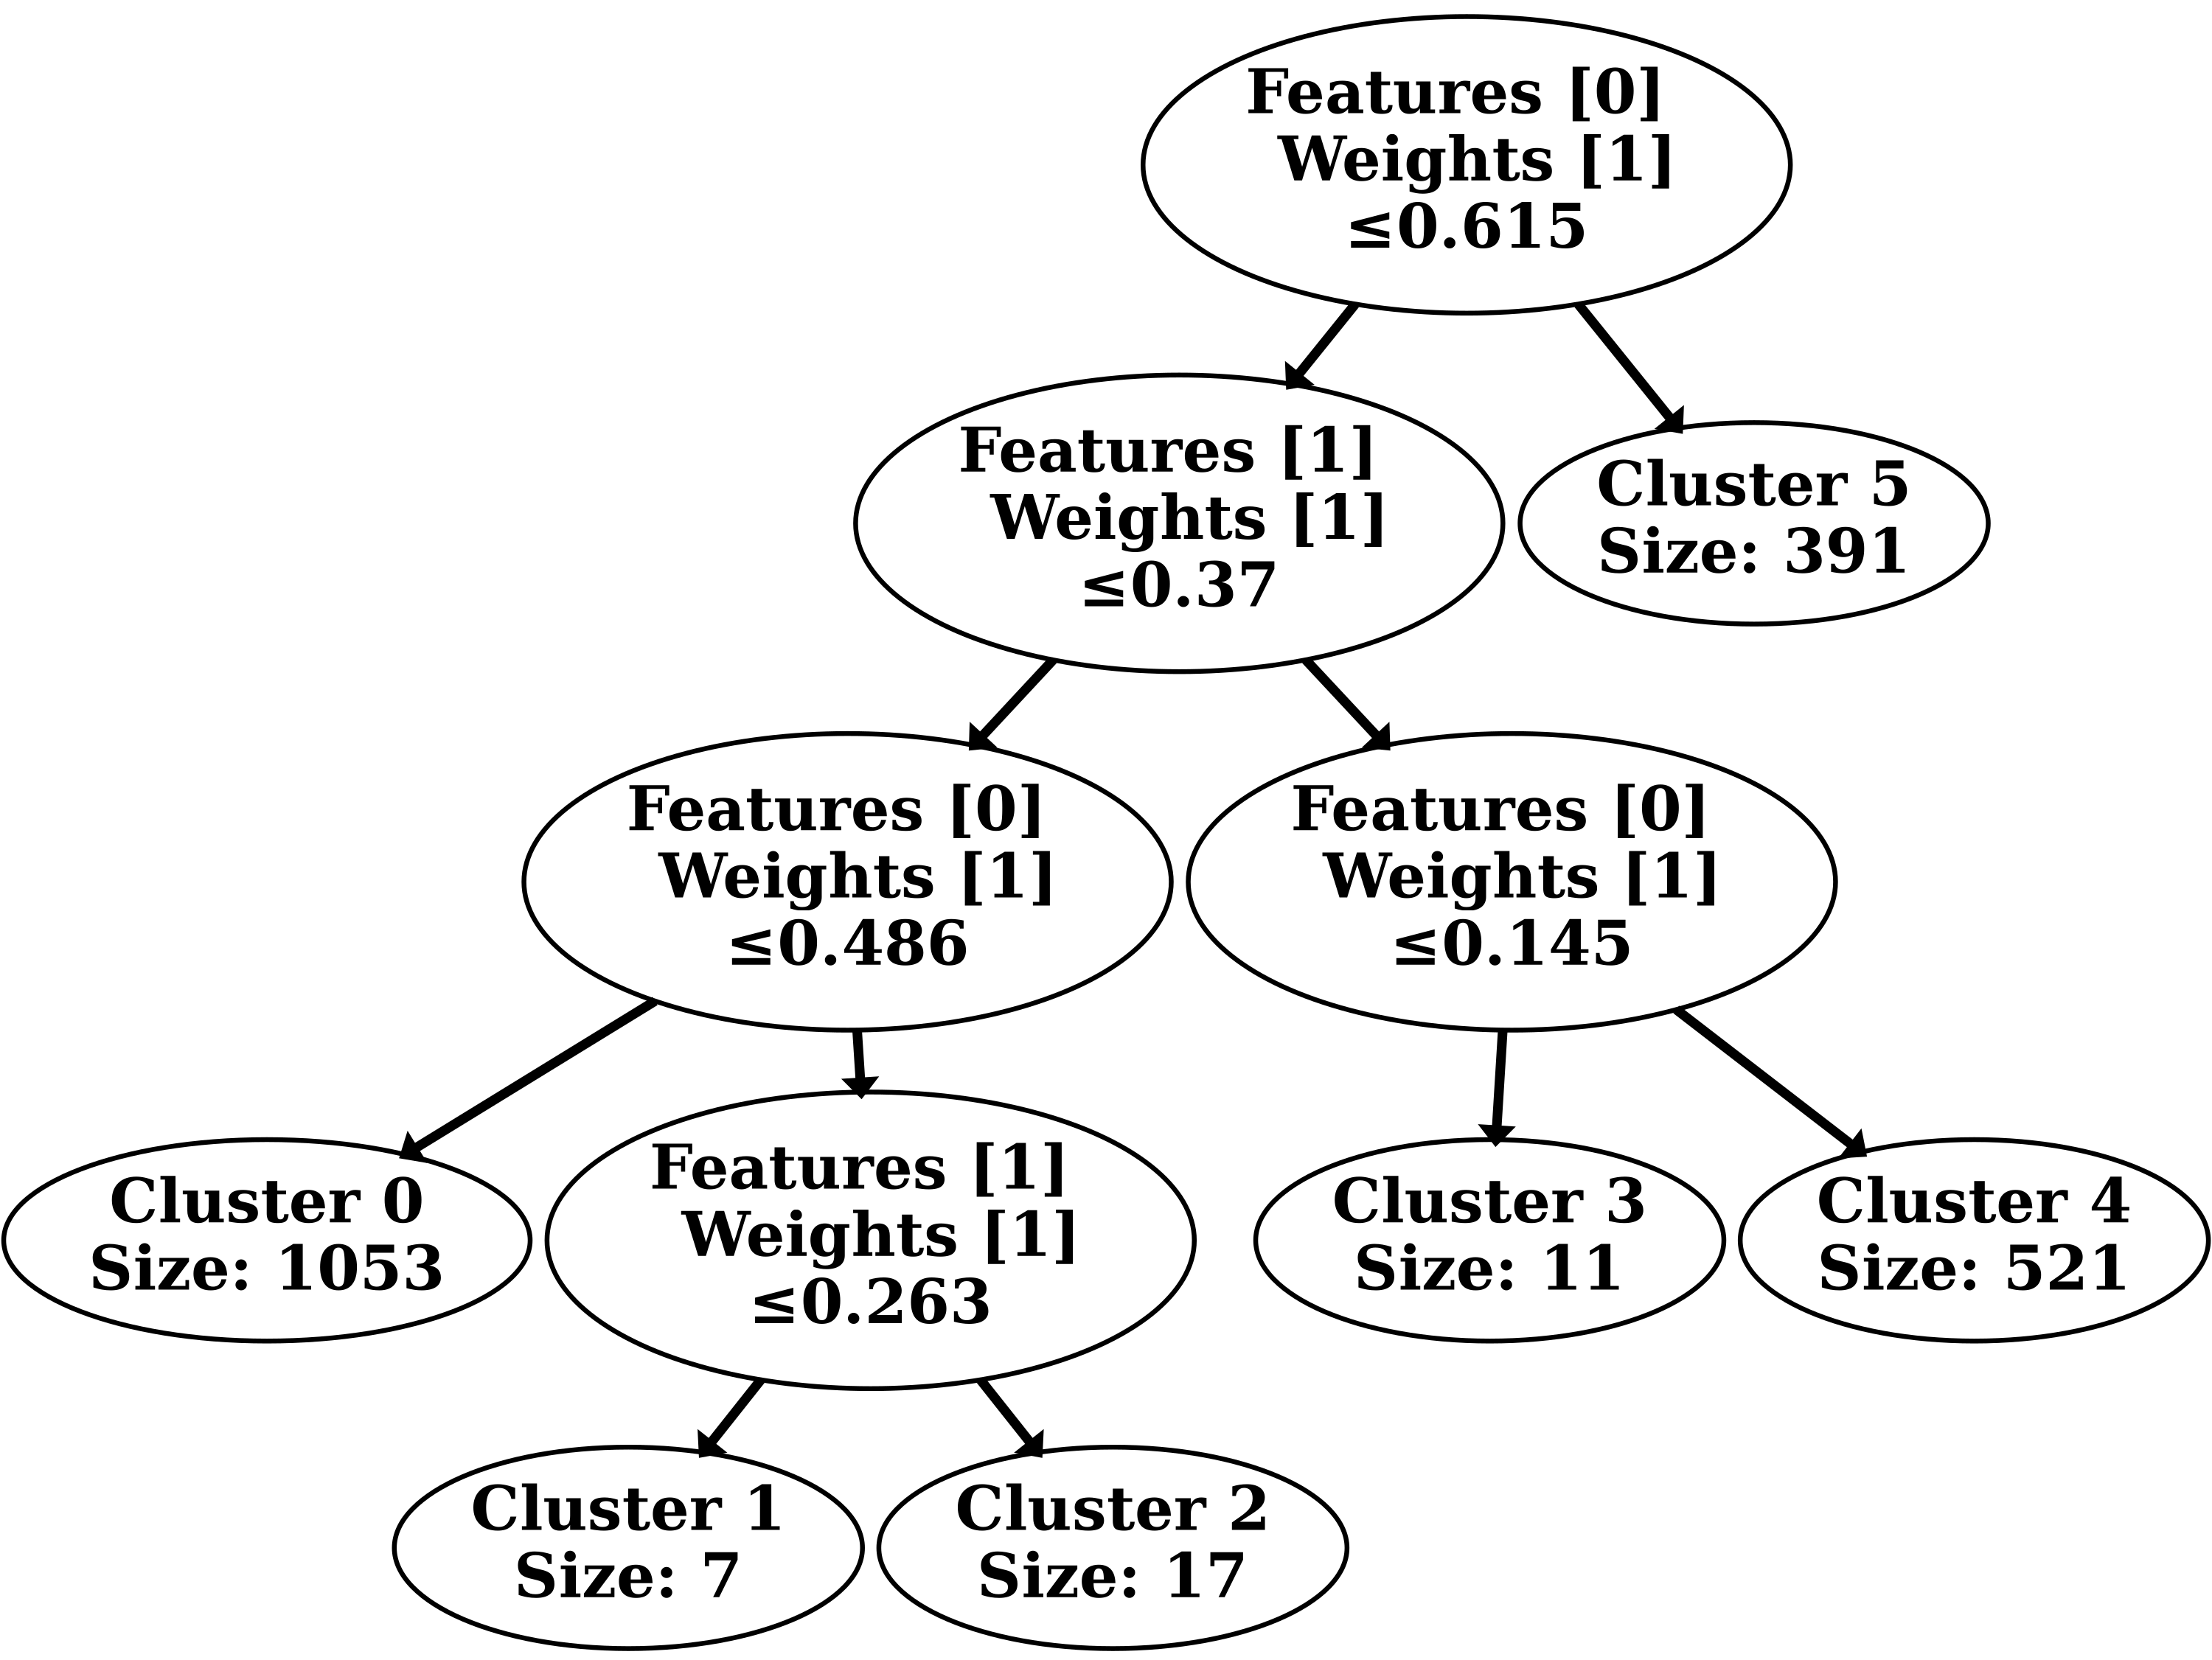

In [77]:
visualize_tree(exkmc_tree.root, cost = False)

### Decision Tree

In [176]:
data_labels = kmeans.labels_
d_tree = SklearnTree(criterion = 'entropy', max_leaf_nodes = 6)
d_tree.fit(data, data_labels)
d_labels = d_tree.predict(data, leaf_labels = False)

Text(0, 0.5, 'y')

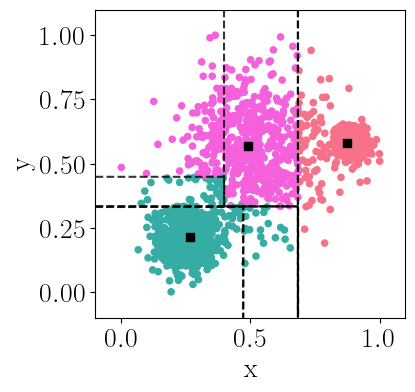

In [177]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = d_labels, cmap = cmap, s = 20)
plot_decision_boundaries(d_tree, data, ax = ax, resolution = 1000)

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'k', s = 30, marker = 's')

ax.set_xlabel('x')
ax.set_ylabel('y')

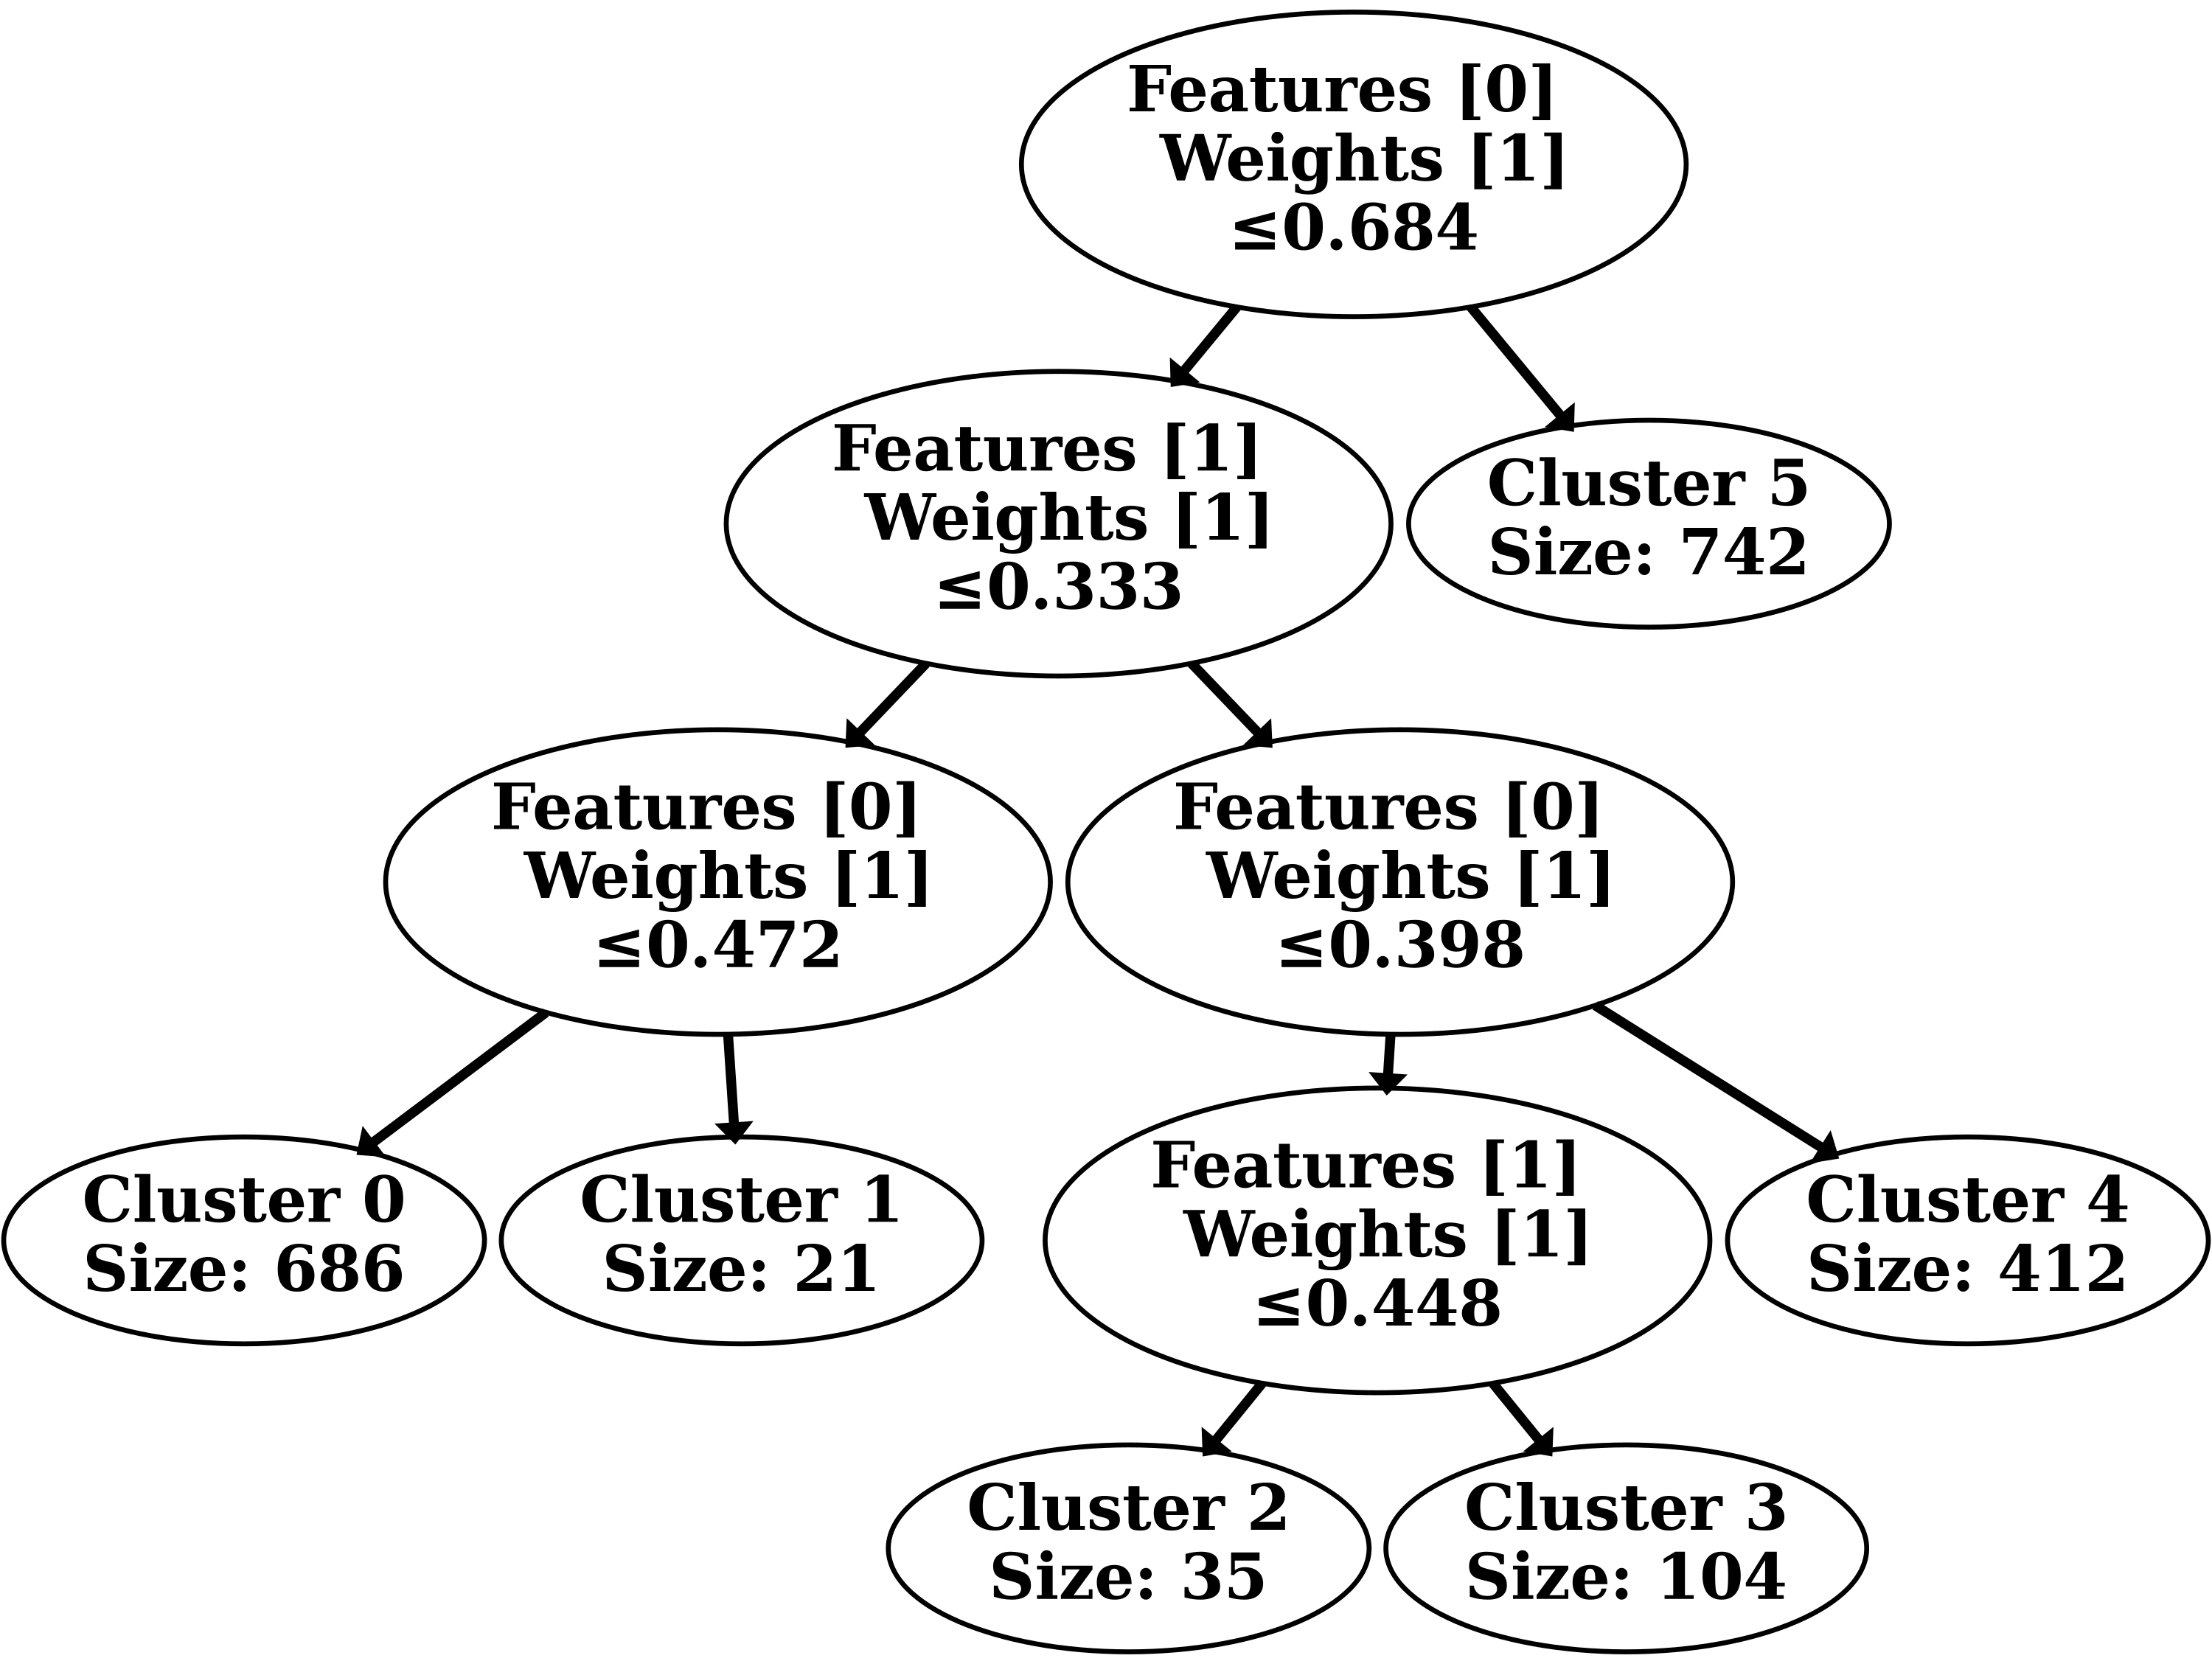

In [17]:
visualize_tree(d_tree.root, cost = False)

### SVM Tree

In [23]:
target_cluster = 2
data_labels = (kmeans.labels_ == target_cluster).astype(int)
svm_tree = SVMTree(max_leaf_nodes = 6)
svm_tree.fit(data, data_labels)
svm_labels = svm_tree.predict(data)

Text(0, 0.5, 'y')

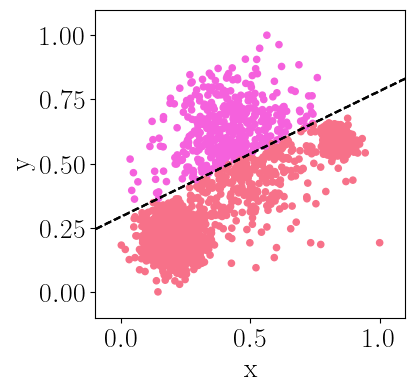

In [24]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = svm_labels, cmap = cmap, s = 20)
plot_decision_boundaries(svm_tree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

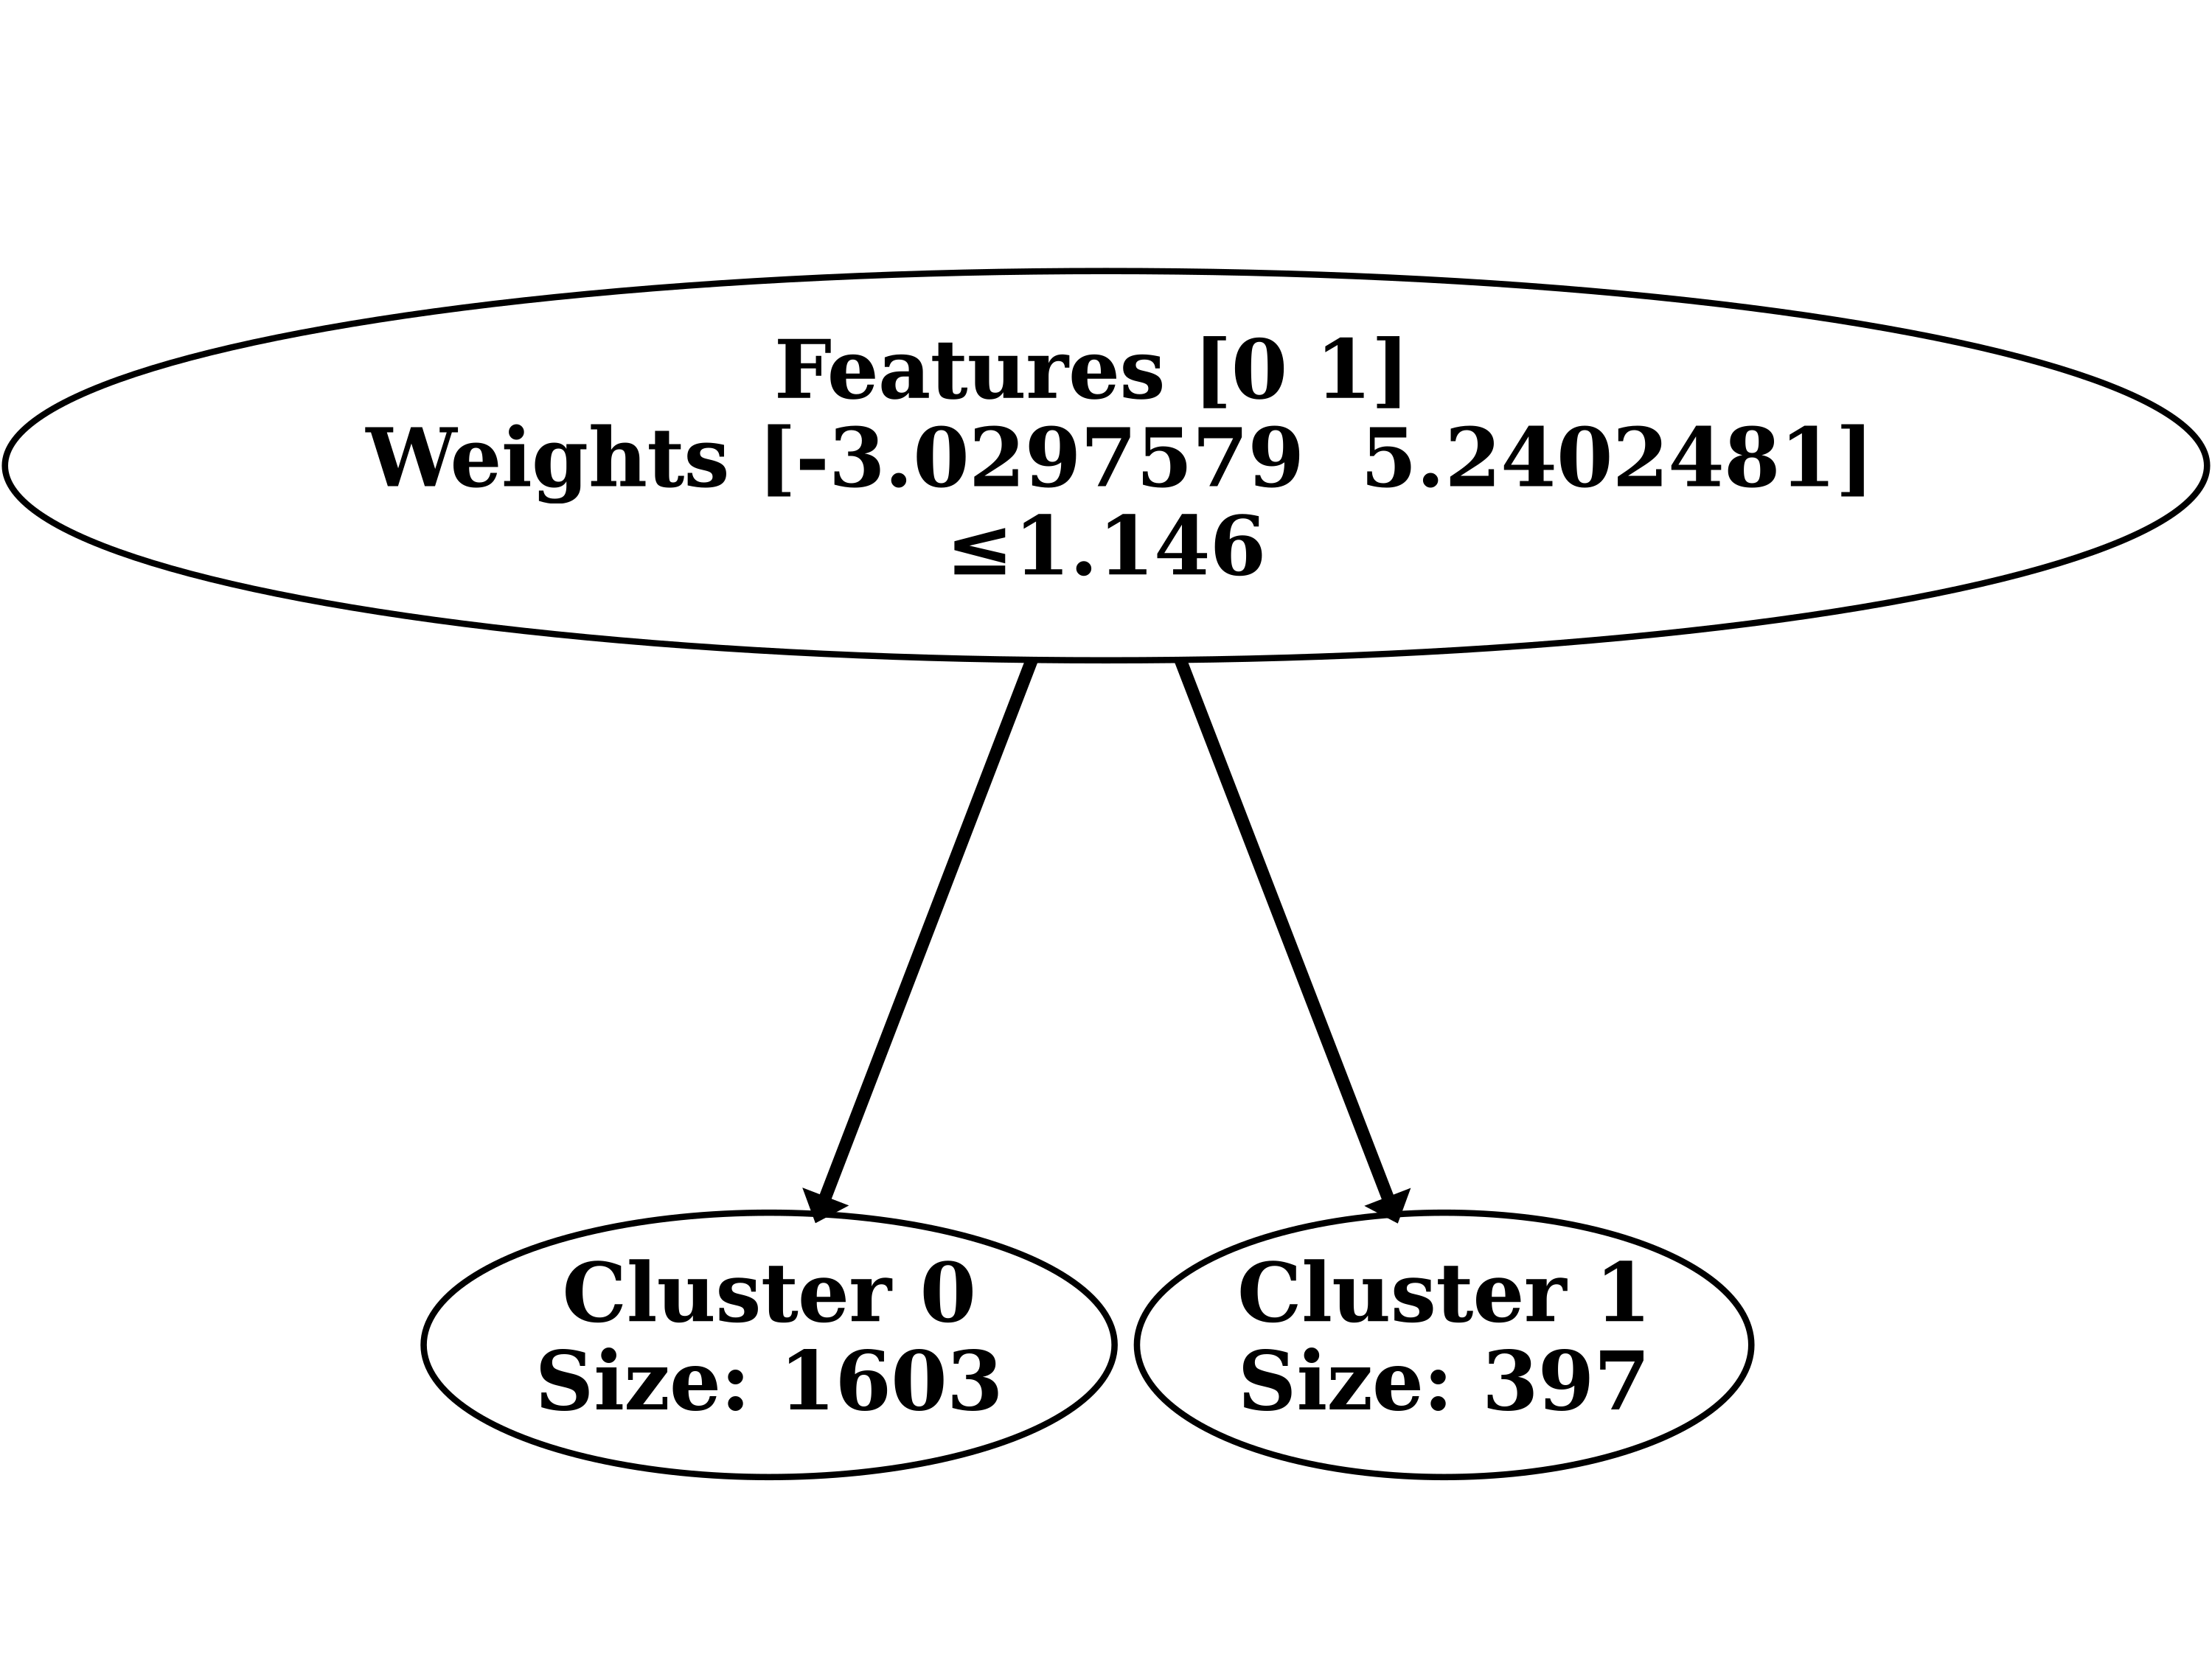

In [20]:
visualize_tree(svm_tree.root, cost = False)

In [42]:
from sklearn.svm import LinearSVC
y = (kmeans.labels_ == 2).astype(int)
#y = kmeans.labels_
svm = LinearSVC().fit(data, y)
svm_labels = svm.predict(data)

Text(0, 0.5, 'y')

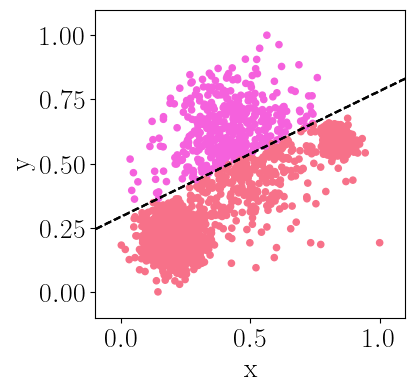

In [43]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = svm_labels, cmap = cmap, s = 20)
plot_decision_boundaries(svm, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [44]:
sub_data = data[np.where(svm_labels == 0)[0],:]
sub_y = y[np.where(svm_labels == 0)[0]]
#sub_y = (kmeans.labels_ == 1).astype(int)[np.where(svm_labels == 0)[0]]
sub_svm = LinearSVC().fit(sub_data, sub_y)
sub_svm_labels = svm.predict(sub_data)

Text(0, 0.5, 'y')

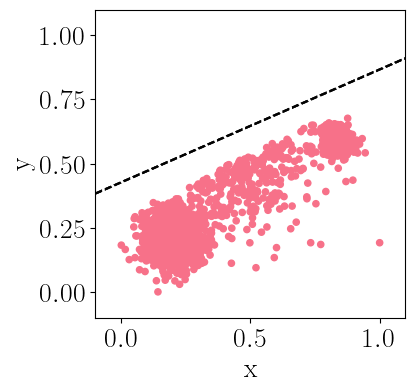

In [45]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(sub_data[:,0], sub_data[:,1], c = sub_svm_labels, cmap = cmap, s = 20)
plot_decision_boundaries(sub_svm, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

## Decision Forest

In [32]:
np.random.seed(918717)

In [33]:
feature_pairings = [[0, 1]]

forest_tree_params = {
    'max_depth' : 3
}

forest = DecisionForest(
    SklearnTree,
    tree_params = forest_tree_params, 
    num_trees = 10,
    max_features = 2,
    max_labels = 1,
    feature_pairings = feature_pairings, 
    train_size = 0.75
)

data_labels = kmeans.labels_
forest.fit(data, data_labels)

In [47]:
k

3

In [67]:
forest_tree_params_exkmc = {
    'k' : k,
    'kmeans' : kmeans,
    'max_leaf_nodes' : 6,
    'imm' : True
}

forest_params_exkmc = {
    'tree_model' : ExkmcTree,
    'tree_params' : forest_tree_params_exkmc,
    'num_trees' : 1,
    'max_features' : 2,
    'max_labels' : k,
    'feature_pairings' : [[0,1]],
    'train_size' : 1
}

forest = DecisionForest(**forest_params_exkmc)
forest.fit(data, kmeans.labels_)

In [72]:
forest.decision_set[-1][0][0].features

array([1])

In [73]:
forest.decision_set[-1][0][0].threshold

0.6101894434644246

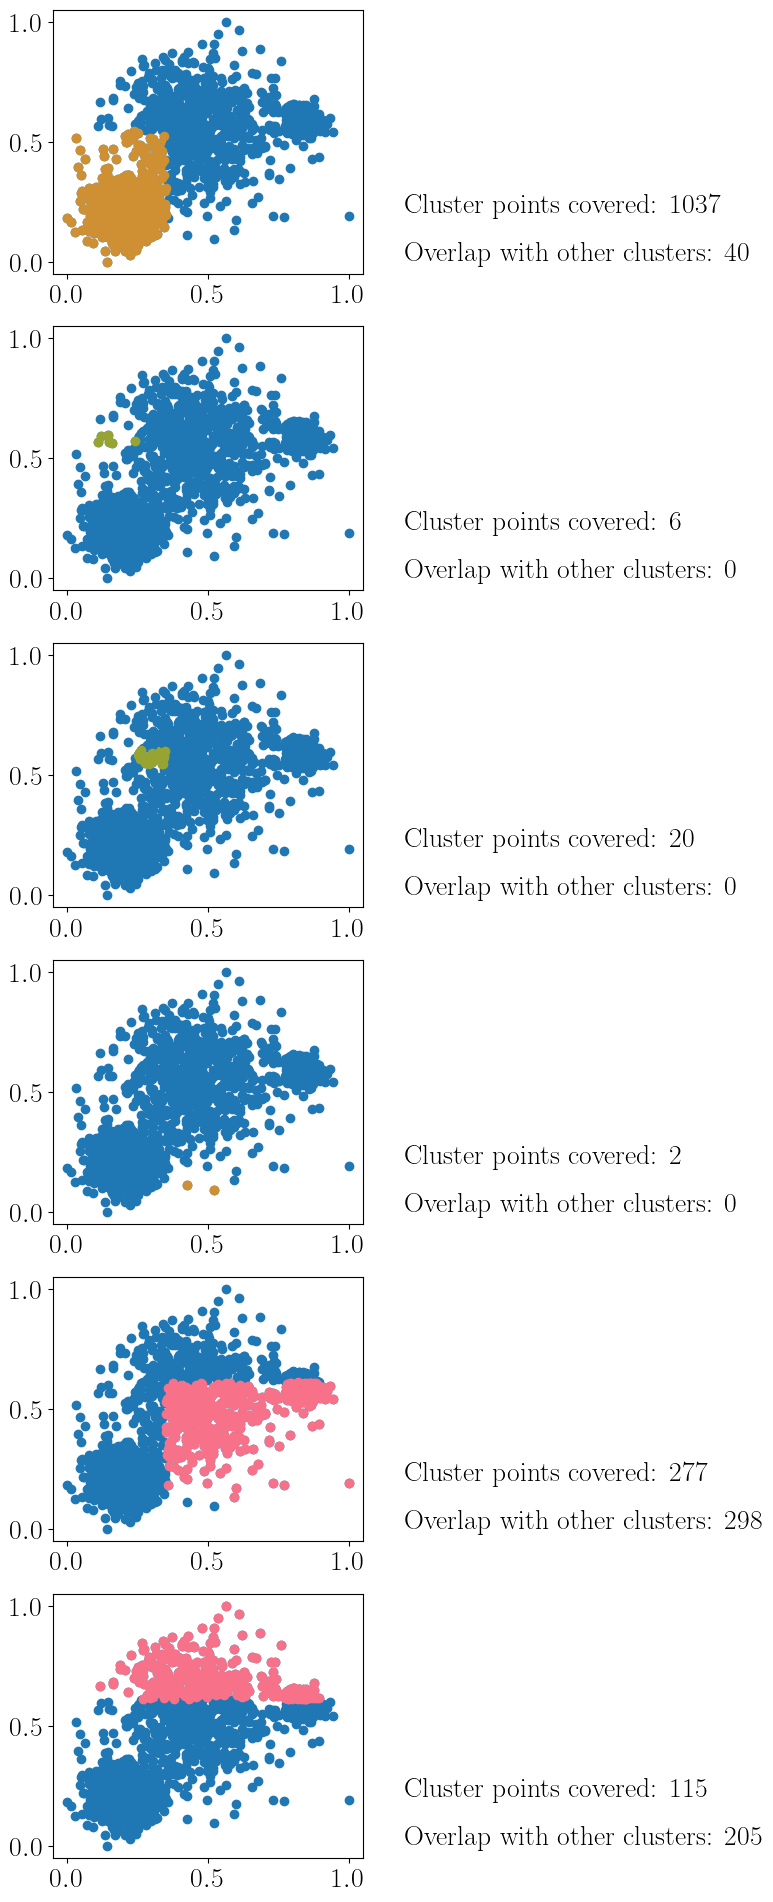

In [68]:
# Visualize points satisfied by each rule
ld = len(forest.decision_set)
fig, ax = plt.subplots(ld, 1, figsize = (4,4 * ld))

for i, decision_path in enumerate(forest.decision_set):
    r_label = forest.decision_set_labels[i]
    indices = satisfies_path(data, decision_path)
    ax[i].scatter(data[:, 0], data[:, 1])
    ax[i].scatter(data[indices, 0], data[indices, 1], color = cmap(r_label))
    points_covered = np.sum(kmeans.labels_[indices] == r_label)
    n_overlaps = len(indices) - np.sum(kmeans.labels_[indices] == r_label)
    ax[i].text(x = 1.2, y = 0.2, s = "Cluster points covered: " + str(points_covered), ha = 'left')
    ax[i].text(x = 1.2, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')

In [58]:
prune_objective = KmeansObjective(
    X = data,
    centers = kmeans.cluster_centers_,
    normalize = True,
    threshold = 0.9
)

forest.prune(
    q = 3,
    k = 3,
    X = data, 
    y = [[l] for l in kmeans.labels_],
    objective = prune_objective,
    lambda_search_range = np.linspace(0,10,101)
    #lambda_search_range = [100]
)
prune_predictions = forest.pruned_predict(data, rule_labels = False)

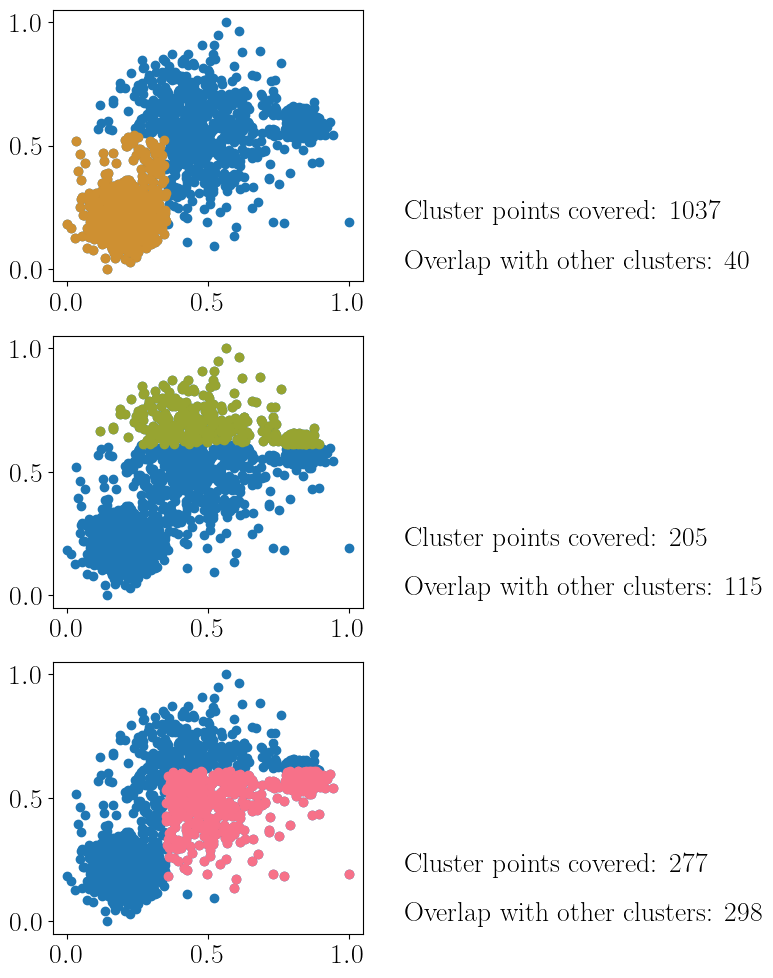

In [59]:
# Visualize rules chosen by pruning
pruned_decision_set = [forest.decision_set[i] for i in forest.pruned_indices]
pruned_decision_set_labels = [forest.decision_set_labels[i] for i in forest.pruned_indices]
ld = len(pruned_decision_set)
fig, ax = plt.subplots(ld, 1, figsize = (4,4 * ld))

for i, decision_path in enumerate(pruned_decision_set):
    r_label = forest.decision_set_labels[forest.pruned_indices[i]]
    indices = satisfies_path(data, decision_path)
    points_covered = np.sum(kmeans.labels_[indices] == r_label)
    n_overlaps = len(indices) - np.sum(kmeans.labels_[indices] == r_label)
    if ld > 1:
        ax[i].scatter(data[:, 0], data[:, 1])
        ax[i].scatter(data[indices, 0], data[indices, 1], color = cmap(pruned_decision_set_labels[i]))
        ax[i].text(x = 1.2, y = 0.2, s = "Cluster points covered: " + str(points_covered), ha = 'left')
        ax[i].text(x = 1.2, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')
    else:
        ax.scatter(data[:, 0], data[:, 1])
        ax.scatter(data[indices, 0], data[indices, 1], color = cmap(pruned_decision_set_labels[i]))
        ax.text(x = 1.2, y = 0.2, s = "Cluster points covered: " + str(points_covered), ha = 'left')
        ax.text(x = 1.2, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')

In [ ]:
'''
feature_pairings = [[0, 1]]

forest_tree_params = {
    'k' : k,
    'kmeans' : kmeans,
    'max_leaf_nodes' : 8,
    'imm' : True
}

forest = DecisionForest(
    ExkmcTree,
    tree_params = forest_tree_params, 
    num_trees = 1,
    max_features = 2,
    max_labels = k,
    feature_pairings = feature_pairings, 
    train_size = 0.75
)

data_labels = kmeans.labels_
forest.fit(data, data_labels)
'''

## Voronoi Decision Sets

In [80]:
np.random.seed(919817)

In [81]:
centers = kmeans.cluster_centers_

In [100]:
vor = VoronoiSet(
    centers = centers, 
    num_sets = 10,
    num_conditions = 2,
    feature_pairings = [[0,1]]
)
data_labels = kmeans.labels_
vor.fit(data, data_labels)

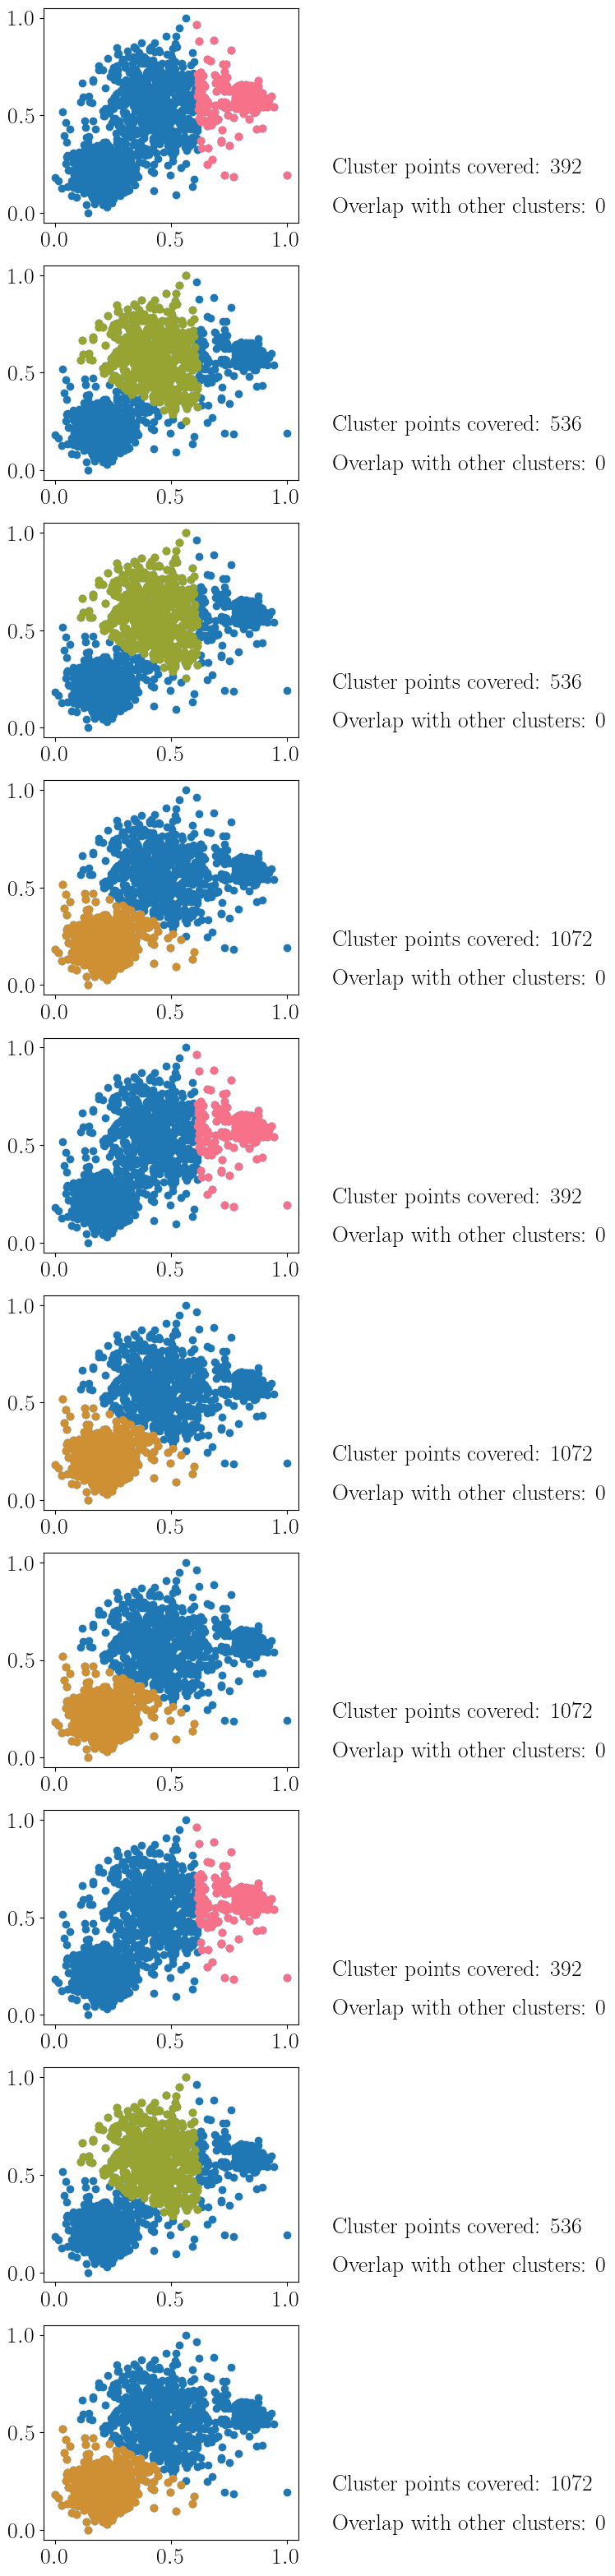

In [101]:
# Visualize points satisfied by each rule
ld = len(vor.decision_set)
fig, ax = plt.subplots(ld, 1, figsize = (4,4 * ld))

for i, cond_list in enumerate(vor.decision_set):
    r_label = vor.decision_set_labels[i][0]
    indices = satisfies_conditions(data, cond_list)
    ax[i].scatter(data[:, 0], data[:, 1])
    ax[i].scatter(data[indices, 0], data[indices, 1], color = cmap(r_label))
    points_covered = np.sum(kmeans.labels_[indices] == r_label)
    n_overlaps = len(indices) - np.sum(kmeans.labels_[indices] == r_label)
    ax[i].text(x = 1.2, y = 0.2, s = "Cluster points covered: " + str(points_covered), ha = 'left')
    ax[i].text(x = 1.2, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')

In [102]:
prune_objective = KmeansObjective(
    X = data,
    centers = kmeans.cluster_centers_,
    normalize = True,
    threshold = 1
)

vor.prune(
    q = 3,
    k = 3,
    X = data, 
    y = [[l] for l in kmeans.labels_],
    objective = prune_objective,
    #lambda_search_range = np.linspace(0,100,101)
    lambda_search_range = [1]
)
prune_predictions = vor.pruned_predict(data, rule_labels = False)

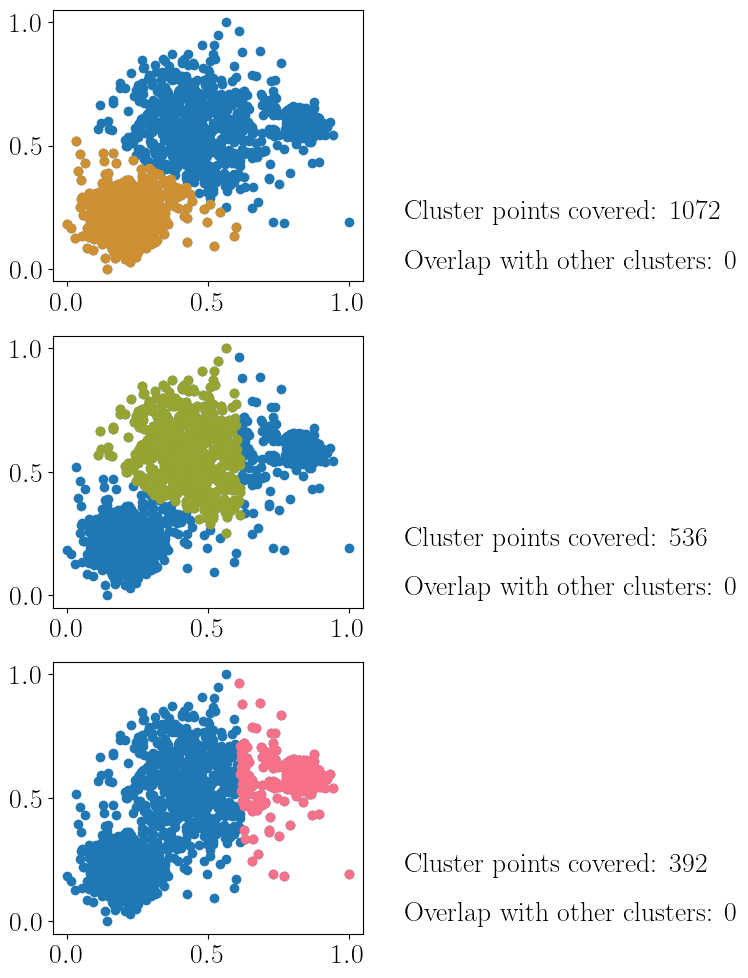

In [103]:
# Visualize rules chosen by pruning
pruned_decision_set = [vor.decision_set[i] for i in vor.pruned_indices]
pruned_decision_set_labels = [vor.decision_set_labels[i] for i in vor.pruned_indices]
ld = len(pruned_decision_set)
fig, ax = plt.subplots(ld, 1, figsize = (4,4 * ld))

for i, cond_list in enumerate(pruned_decision_set):
    r_label = vor.decision_set_labels[vor.pruned_indices[i]]
    indices = satisfies_conditions(data, cond_list)
    points_covered = np.sum(kmeans.labels_[indices] == r_label)
    n_overlaps = len(indices) - np.sum(kmeans.labels_[indices] == r_label)
    if ld > 1:
        ax[i].scatter(data[:, 0], data[:, 1])
        ax[i].scatter(data[indices, 0], data[indices, 1], color = cmap(pruned_decision_set_labels[i]))
        ax[i].text(x = 1.2, y = 0.2, s = "Cluster points covered: " + str(points_covered), ha = 'left')
        ax[i].text(x = 1.2, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')
    else:
        ax.scatter(data[:, 0], data[:, 1])
        ax.scatter(data[indices, 0], data[indices, 1], color = cmap(pruned_decision_set_labels[i]))
        ax.text(x = 1.2, y = 0.2, s = "Cluster points covered: " + str(points_covered), ha = 'left')
        ax.text(x = 1.2, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')

# Measuring Outcomes

In [344]:
# REMINDER: The seed should only be given to the experiment object which 
# initializes the seed at the beginning of the experiment. It should NOT 
# within the parameters of any sub-function or class, since these will 
# reset the seed each time they are given one. 
np.random.seed(919817)

In [345]:
# PARAMETERS:
k = 3
n_clusters = k
min_rules = k
max_rules = 2*k
min_depth = 1
max_depth = None
n_trees = 100

# Base module
base = KMeansBase(n_clusters)
A,C = base.assign(data)
y = base.clustering.labels_

# Depth 2 Forest:
forest_tree_params_depth_2 = {
    'max_leaf_nodes' : max_rules,
    'max_depth' : 2
}

forest_params_depth_2 = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_2,
    'num_trees' : n_trees,
    'max_features' : 2,
    'max_labels' : 1,
    'feature_pairings' : [[0, 1]],
    'train_size' : 0.75
}

# Depth 5 Forest:
forest_tree_params_depth_3 = {
    'max_leaf_nodes' : max_rules,
    'max_depth' : 3
}

forest_params_depth_3 = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_3,
    'num_trees' : n_trees,
    'max_features' : 2,
    'max_labels' : 1,
    'feature_pairings' : [[0, 1]],
    'train_size' : 0.75
}

# SVM Forest:
forest_tree_params_svm = {
    'max_leaf_nodes' : max_rules,
    'max_depth' : 1
}

forest_params_svm = {
    'tree_model' : SVMTree,
    'tree_params' : forest_tree_params_svm,
    'num_trees' : n_trees,
    'max_features' : 2,
    'max_labels' : 1,
    'feature_pairings' : [[0, 1]],
    'train_size' : 0.75
}


# ExKMC Forest:
forest_tree_params_exkmc = {
    'k' : k,
    'kmeans' : kmeans,
    'max_leaf_nodes' : 2*k,
    'imm' : True
}

forest_params_exkmc = {
    'tree_model' : ExkmcTree,
    'tree_params' : forest_tree_params_exkmc,
    'num_trees' : n_trees,
    'max_features' : 2,
    'max_labels' : 1,
    'feature_pairings' : [[0, 1]],
    'train_size' : 0.75
}

prune_objective_cover_90 = KmeansObjective(
    X = data,
    centers = C,
    normalize = True,
    threshold = 0.9
)

prune_params_cover_90 = {
    'k' : k,
    'X' : data,
    'y' : [[l] for l in y],
    'objective' : prune_objective_cover_90,
    'lambda_search_range' : np.linspace(0,2,101)
}

prune_objective_cover_100 = KmeansObjective(
    X = data,
    centers = C,
    normalize = True,
    threshold = 1
)

prune_params_cover_100 = {
    'k' : k,
    'X' : data,
    'y' : [[l] for l in y],
    'objective' : prune_objective_cover_100,
    'lambda_search_range' : np.linspace(0,2,101)
}

prune_objective_cover_50 = KmeansObjective(
    X = data,
    centers = C,
    normalize = True,
    threshold = 0.5
)

prune_params_cover_50 = {
    'k' : k,
    'X' : data,
    'y' : [[l] for l in y],
    'objective' : prune_objective_cover_50,
    'lambda_search_range' : np.linspace(0,2,101)
}

In [346]:
# MODULES: 
exkmc_mod = ExkmcMod(
    n_clusters = n_clusters,
    kmeans_model = base.clustering,
    base_tree = 'IMM',
    min_rules = min_rules
)

mod1 = ForestMod(
    forest_model = DecisionForest,
    forest_params = forest_params_depth_2,
    clustering = base,
    prune_params = prune_params_cover_90,
    min_rules = min_rules,
    min_depth = min_depth,
    max_rules = max_rules,
    max_depth = max_depth,
    name = 'Forest'
)


mod2 = ForestMod(
    forest_model = DecisionForest,
    forest_params = forest_params_depth_2,
    clustering = base,
    prune_params = prune_params_cover_100,
    min_rules = min_rules,
    min_depth = min_depth,
    max_rules = max_rules,
    max_depth = max_depth,
    name = 'Forest-Full-Cover'
)


mod3 = ForestMod(
    forest_model = DecisionForest,
    forest_params = forest_params_svm,
    clustering = base,
    prune_params = prune_params_cover_50,
    min_rules = min_rules,
    min_depth = min_depth,
    max_rules = max_rules,
    max_depth = max_depth,
    name = 'SVM-Forest'
)

# Forest:
mod4 = ForestMod(
    forest_model = DecisionForest,
    forest_params = forest_params_depth_3,
    clustering = base,
    prune_params = prune_params_cover_90,
    min_rules = min_rules,
    min_depth = min_depth,
    max_rules = max_rules,
    max_depth = max_depth,
    name = 'Forest-Depth-3'
)


mod5 = ForestMod(
    forest_model = DecisionForest,
    forest_params = forest_params_exkmc,
    clustering = base,
    prune_params = prune_params_cover_90,
    min_rules = min_rules,
    min_depth = min_depth,
    max_rules = max_rules,
    max_depth = max_depth,
    name = 'Forest-Exkmc'
)


baseline_list = [base]
module_list = [exkmc_mod, mod1, mod2, mod3, mod4, mod5]

measurement_fns = [
    ClusteringCost(average = True, normalize = False),
    ClusteringCost(average = True, normalize = True),
    Overlap(),
    Coverage(), 
    OverlapDistance(),
]

### Experiment 1: Changing the number of rules

In [347]:
n_samples = 5

exp = RulesExperiment(
    data = data,
    baseline_list = baseline_list,
    module_list = module_list,
    measurement_fns = measurement_fns,
    n_samples = n_samples,
    labels = y,
    random_seed = seed,
    verbose = True
)

exp_results = exp.run(min_rules = min_rules, max_rules = max_rules)

Running for sample 0.
Running for 3 rules.


/home/kevinq/interpretable/intercluster/pruning/prune.py:188: UserWarning: Coverage requirements not met. Consider adjusting requirements or increasing the search range for lambda.
  warnings.warn(


Running for 4 rules.
Running for 5 rules.
Running for 6 rules.

Running for sample 1.
Running for 3 rules.


/home/kevinq/interpretable/intercluster/pruning/prune.py:188: UserWarning: Coverage requirements not met. Consider adjusting requirements or increasing the search range for lambda.
  warnings.warn(


Running for 4 rules.


/home/kevinq/interpretable/intercluster/pruning/prune.py:188: UserWarning: Coverage requirements not met. Consider adjusting requirements or increasing the search range for lambda.
  warnings.warn(


Running for 5 rules.
Running for 6 rules.

Running for sample 2.
Running for 3 rules.


/home/kevinq/interpretable/intercluster/pruning/prune.py:188: UserWarning: Coverage requirements not met. Consider adjusting requirements or increasing the search range for lambda.
  warnings.warn(


Running for 4 rules.


/home/kevinq/interpretable/intercluster/pruning/prune.py:188: UserWarning: Coverage requirements not met. Consider adjusting requirements or increasing the search range for lambda.
  warnings.warn(


Running for 5 rules.
Running for 6 rules.

Running for sample 3.
Running for 3 rules.


/home/kevinq/interpretable/intercluster/pruning/prune.py:188: UserWarning: Coverage requirements not met. Consider adjusting requirements or increasing the search range for lambda.
  warnings.warn(


Running for 4 rules.
Running for 5 rules.
Running for 6 rules.

Running for sample 4.
Running for 3 rules.


/home/kevinq/interpretable/intercluster/pruning/prune.py:188: UserWarning: Coverage requirements not met. Consider adjusting requirements or increasing the search range for lambda.
  warnings.warn(


Running for 4 rules.


/home/kevinq/interpretable/intercluster/pruning/prune.py:188: UserWarning: Coverage requirements not met. Consider adjusting requirements or increasing the search range for lambda.
  warnings.warn(


Running for 5 rules.
Running for 6 rules.



In [348]:
grouped = exp_results.T.groupby(level = [0,1])
mean_df = grouped.mean().T
std_df = grouped.std().T

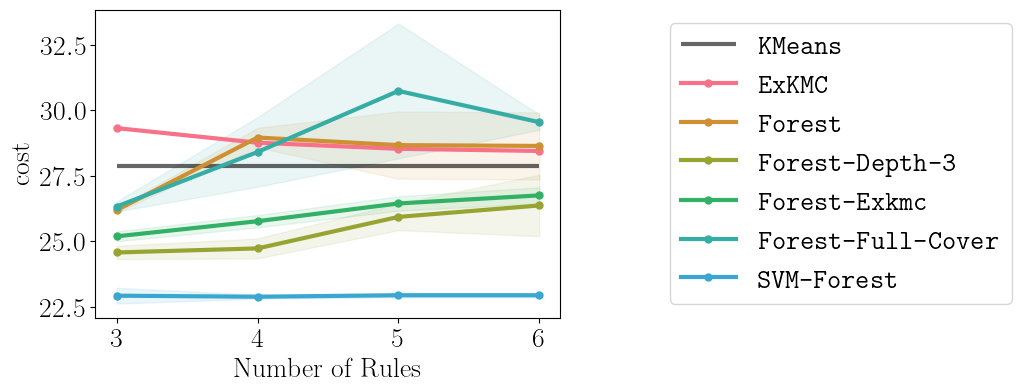

In [349]:
fname = None
#fname = '../figures/decision_sets/cost.png'
experiment_plotter(
    mean_df['point-average-clustering-cost'],
    std_df['point-average-clustering-cost'],
    xlabel = 'Number of Rules',
    ylabel = 'cost',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap,
    legend = True,
    filename = fname
)

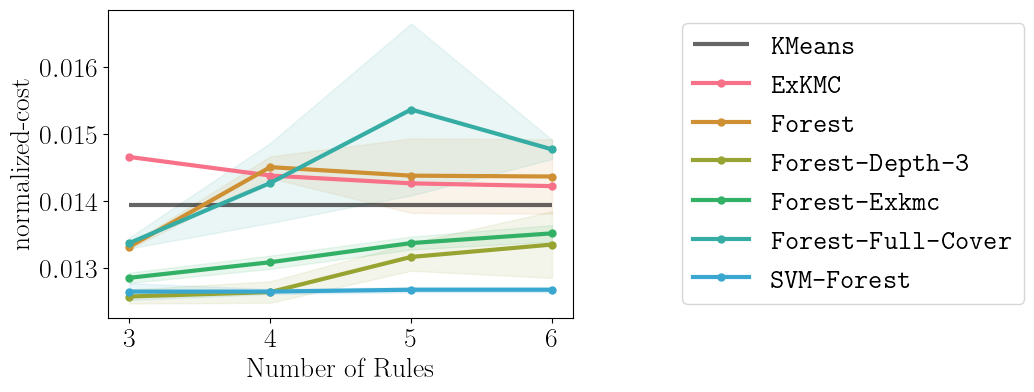

In [350]:
fname = None
#fname = '../figures/decision_sets/normalized_cost.png'
experiment_plotter(
    mean_df['normalized-clustering-cost'],
    std_df['normalized-clustering-cost'],
    xlabel = 'Number of Rules',
    ylabel = 'normalized-cost',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap,
    legend = True,
    filename = fname
)

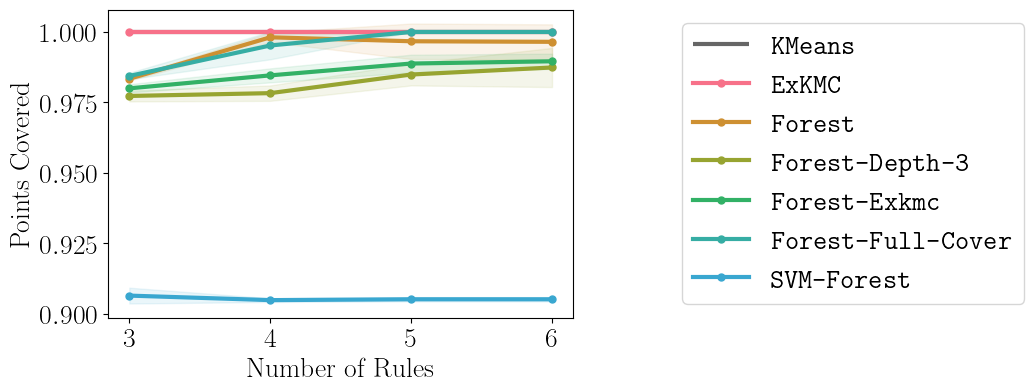

In [351]:
fname = None
#fname = '../figures/decision_sets/coverage.png'
experiment_plotter(
    mean_df['coverage'],
    std_df['coverage'],
    xlabel = 'Number of Rules',
    ylabel = 'Points Covered',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap,
    legend = True,
    filename = fname
)

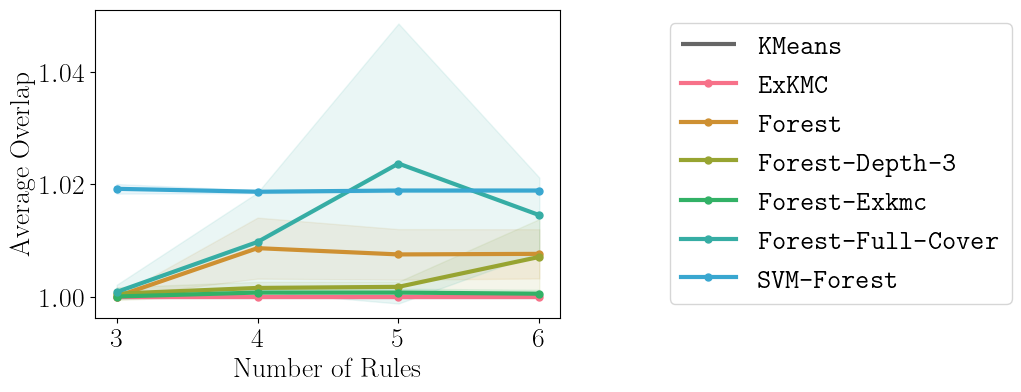

In [352]:
fname = None
#fname = '../figures/decision_sets/overlap.png'
experiment_plotter(
    mean_df['overlap'],
    std_df['overlap'],
    xlabel = 'Number of Rules',
    ylabel = 'Average Overlap',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap,
    legend = True,
    filename = None
)

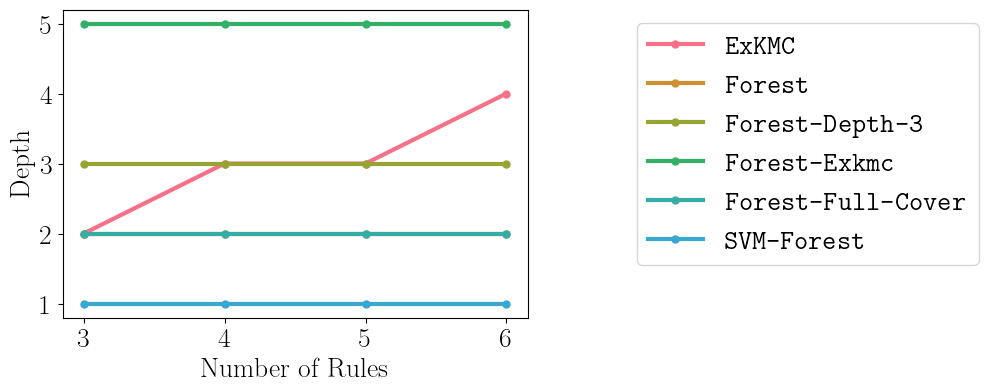

In [353]:
fname = None
#fname = '../figures/decision_sets/depth.png'
experiment_plotter(
    mean_df['depth'],
    std_df['depth'],
    xlabel = 'Number of Rules',
    ylabel = 'Depth',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap,
    legend = True,
    filename = fname
)

### Experiment 2: Using the covered points from Forest

In [203]:
measurement_fns = [
    ClusteringCost(average = True, normalize = False)
]

n_samples = 10

exp2 = RulesExperimentV2(
    data = data,
    comparison_module = mod1,
    baseline_list = baseline_list,
    module_list = [exkmc_mod],
    measurement_fns = measurement_fns,
    n_samples = n_samples,
    labels = y,
    random_seed = seed,
    verbose = True
)

exp2_results = exp2.run(min_rules = min_rules, max_rules = max_rules)

Running Comparison Module:
Running for Modules sample 0.
Running for 3 rules.
Running for 4 rules.
Running for 5 rules.
Running for 6 rules.

Running for Modules sample 1.
Running for 3 rules.
Running for 4 rules.
Running for 5 rules.
Running for 6 rules.

Running for Modules sample 2.
Running for 3 rules.
Running for 4 rules.
Running for 5 rules.
Running for 6 rules.

Running for Modules sample 3.
Running for 3 rules.
Running for 4 rules.
Running for 5 rules.
Running for 6 rules.

Running for Modules sample 4.
Running for 3 rules.
Running for 4 rules.
Running for 5 rules.
Running for 6 rules.

Running for Modules sample 5.
Running for 3 rules.
Running for 4 rules.
Running for 5 rules.
Running for 6 rules.

Running for Modules sample 6.
Running for 3 rules.
Running for 4 rules.
Running for 5 rules.
Running for 6 rules.

Running for Modules sample 7.
Running for 3 rules.
Running for 4 rules.
Running for 5 rules.
Running for 6 rules.

Running for Modules sample 8.
Running for 3 rules.
Ru

In [204]:
grouped = exp2_results.T.groupby(level = [0,1])
mean_df2 = grouped.mean().T
std_df2 = grouped.std().T

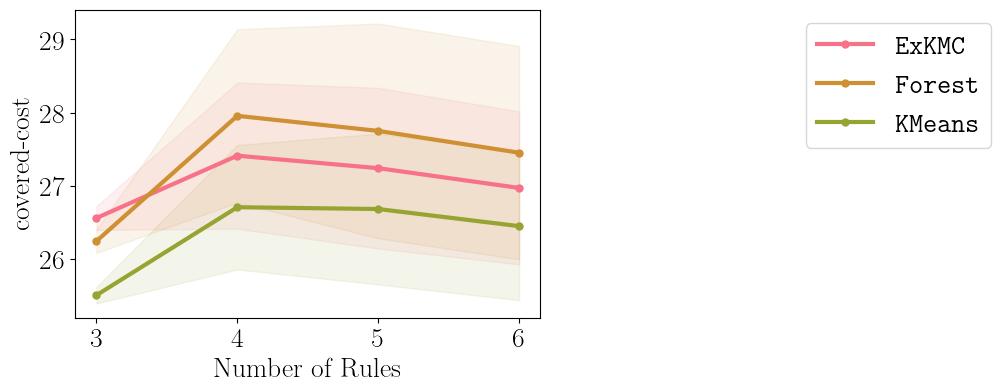

In [205]:
fname = None
experiment_plotter(
    mean_df2['point-average-clustering-cost'],
    std_df2['point-average-clustering-cost'],
    xlabel = 'Number of Rules',
    ylabel = 'covered-cost',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap,
    legend = True,
    filename = fname,
    baseline_list = []
)

In [206]:
measurement_fns = [
    ClusteringCost(average = True, normalize = False)
]

n_samples = 10

exp3 = RulesExperimentV2(
    data = data,
    comparison_module = mod4,
    baseline_list = baseline_list,
    module_list = [exkmc_mod],
    measurement_fns = measurement_fns,
    n_samples = n_samples,
    labels = y,
    random_seed = seed,
    verbose = True
)

exp3_results = exp3.run(min_rules = min_rules, max_rules = max_rules)

Running Comparison Module:
Running for Modules sample 0.
Running for 3 rules.
Running for 4 rules.
Running for 5 rules.
Running for 6 rules.

Running for Modules sample 1.
Running for 3 rules.
Running for 4 rules.
Running for 5 rules.
Running for 6 rules.

Running for Modules sample 2.
Running for 3 rules.
Running for 4 rules.
Running for 5 rules.
Running for 6 rules.

Running for Modules sample 3.
Running for 3 rules.
Running for 4 rules.
Running for 5 rules.
Running for 6 rules.

Running for Modules sample 4.
Running for 3 rules.
Running for 4 rules.
Running for 5 rules.
Running for 6 rules.

Running for Modules sample 5.
Running for 3 rules.
Running for 4 rules.
Running for 5 rules.
Running for 6 rules.

Running for Modules sample 6.
Running for 3 rules.
Running for 4 rules.
Running for 5 rules.
Running for 6 rules.

Running for Modules sample 7.
Running for 3 rules.
Running for 4 rules.
Running for 5 rules.
Running for 6 rules.

Running for Modules sample 8.
Running for 3 rules.
Ru

In [207]:
grouped = exp3_results.T.groupby(level = [0,1])
mean_df3 = grouped.mean().T
std_df3 = grouped.std().T

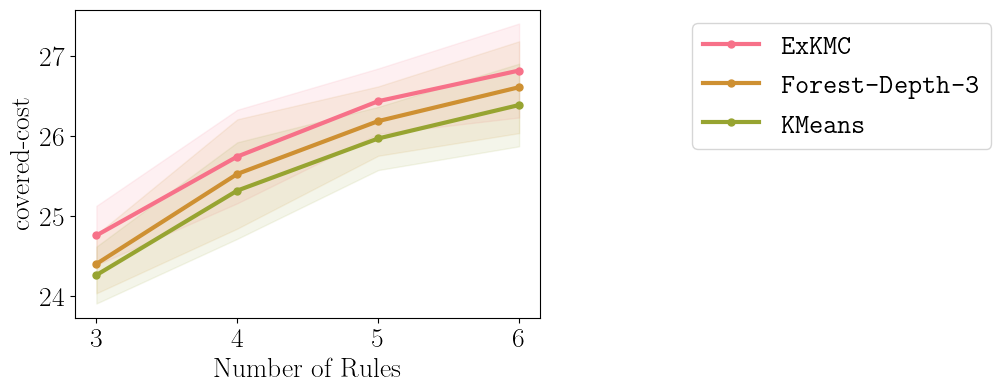

In [208]:
fname = None
experiment_plotter(
    mean_df3['point-average-clustering-cost'],
    std_df3['point-average-clustering-cost'],
    xlabel = 'Number of Rules',
    ylabel = 'covered-cost',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap,
    legend = True,
    filename = fname,
    baseline_list = []
)